# CUPED Benchmarking DGPs

Three scenarios for testing variance reduction:
1. Continuous outcome, moderate correlation ($R^2 \approx 0.25$)
2. Binary outcome (harder to gain variance reduction)
3. Continuous outcome, high correlation ($R^2 \approx 0.81$)


In [2]:
import numpy as np
import pandas as pd
from causalis.data.dgps.causaldata.functional import generate_rct
from causalis.data.causaldata import CausalData
from causalis.statistics.models.cuped import CUPEDModel

def check_correlation(df, y_col="y", pre_col="y_pre"):
    # Check correlation in control group
    control = df[df["d"] == 0]
    corr = np.corrcoef(control[y_col], control[pre_col])[0, 1]
    return corr

def run_cuped_analysis(df, name):
    data = CausalData(df=df, treatment='d', outcome='y', confounders=['y_pre'])
    model = CUPEDModel()
    model.fit(data)
    res = model.effect()
    
    print(f"Analysis for {name}:")
    print(f"  True Effect: {df['cate'].mean():.4f}")
    print(f"  Naive ATE:   {res.ate_naive:.4f} (SE: {res.se_naive:.6f})")
    print(f"  CUPED ATE:   {res.ate:.4f} (SE: {res.se:.6f})")
    print(f"  Var Reduction: {res.variance_reduction_pct:.2f}%")
    print("-" * 30)


## 1. Normal Outcome, Moderate Correlation (Target $\rho \approx 0.5$)

In [3]:
df_normal_mod = generate_rct(
    n=100_000,
    outcome_type="normal",
    add_pre=True,
    pre_corr=0.5,
    random_state=42
)
rho = check_correlation(df_normal_mod)
print(f"Scenario 1 (Normal, Mod): Correlation = {rho:.4f}")
df_normal_mod.head()
run_cuped_analysis(df_normal_mod, 'Scenario 1 (Normal, Mod)')

Scenario 1 (Normal, Mod): Correlation = 0.5010
Analysis for Scenario 1 (Normal, Mod):
  True Effect: 0.2000
  Naive ATE:   0.1880 (SE: 0.009563)
  CUPED ATE:   0.1923 (SE: 0.008285)
  Var Reduction: 24.95%
------------------------------


## 2. Binary Outcome (Target $\rho \approx 0.3-0.5$)
Binary outcomes naturally limit the max correlation achievable with a continuous covariate.

In [4]:
df_binary = generate_rct(
    n=100_000,
    outcome_type="binary",
    add_pre=True,
    pre_corr=0.5, # The generator attempts to maximize this within binary constraints
    random_state=42
)
rho = check_correlation(df_binary)
print(f"Scenario 2 (Binary): Correlation = {rho:.4f}")
df_binary.head()
run_cuped_analysis(df_binary, 'Scenario 2 (Binary)')

Scenario 2 (Binary): Correlation = 0.2286
Analysis for Scenario 2 (Binary):
  True Effect: 0.0227
  Naive ATE:   0.0168 (SE: 0.002289)
  CUPED ATE:   0.0173 (SE: 0.002228)
  Var Reduction: 5.32%
------------------------------


## 3. Normal Outcome, High Correlation (Target $\rho \approx 0.9$)

In [5]:
df_normal_high = generate_rct(
    n=100_000,
    outcome_type="normal",
    add_pre=True,
    pre_corr=0.9,
    random_state=42
)
rho = check_correlation(df_normal_high)
print(f"Scenario 3 (Normal, High): Correlation = {rho:.4f}")
df_normal_high.head()
run_cuped_analysis(df_normal_high, 'Scenario 3 (Normal, High)')

Scenario 3 (Normal, High): Correlation = 0.7492
Analysis for Scenario 3 (Normal, High):
  True Effect: 0.2000
  Naive ATE:   0.1880 (SE: 0.009563)
  CUPED ATE:   0.1961 (SE: 0.006326)
  Var Reduction: 56.24%
------------------------------


In [6]:
df_normal_high.columns

Index(['user_id', 'y', 'd', 'x1', 'x2', 'x3', 'x4', 'x5', 'm', 'm_obs',
       'tau_link', 'g0', 'g1', 'cate', 'propensity', 'propensity_obs', 'mu0',
       'mu1', 'y_pre', 'age', 'cnt_trans', 'platform_Android', 'platform_iOS',
       'invited_friend'],
      dtype='object')

In [7]:
data = CausalData(df=df_normal_high, treatment='d', outcome='y', confounders=['y_pre', 'age', 'cnt_trans', 'platform_Android', 'platform_iOS',
       'invited_friend'])


In [8]:
from causalis.eda import CausalEDA
eda = CausalEDA(data)

# shape of data
eda.data_shape()

{'n_rows': 100000, 'n_columns': 8}

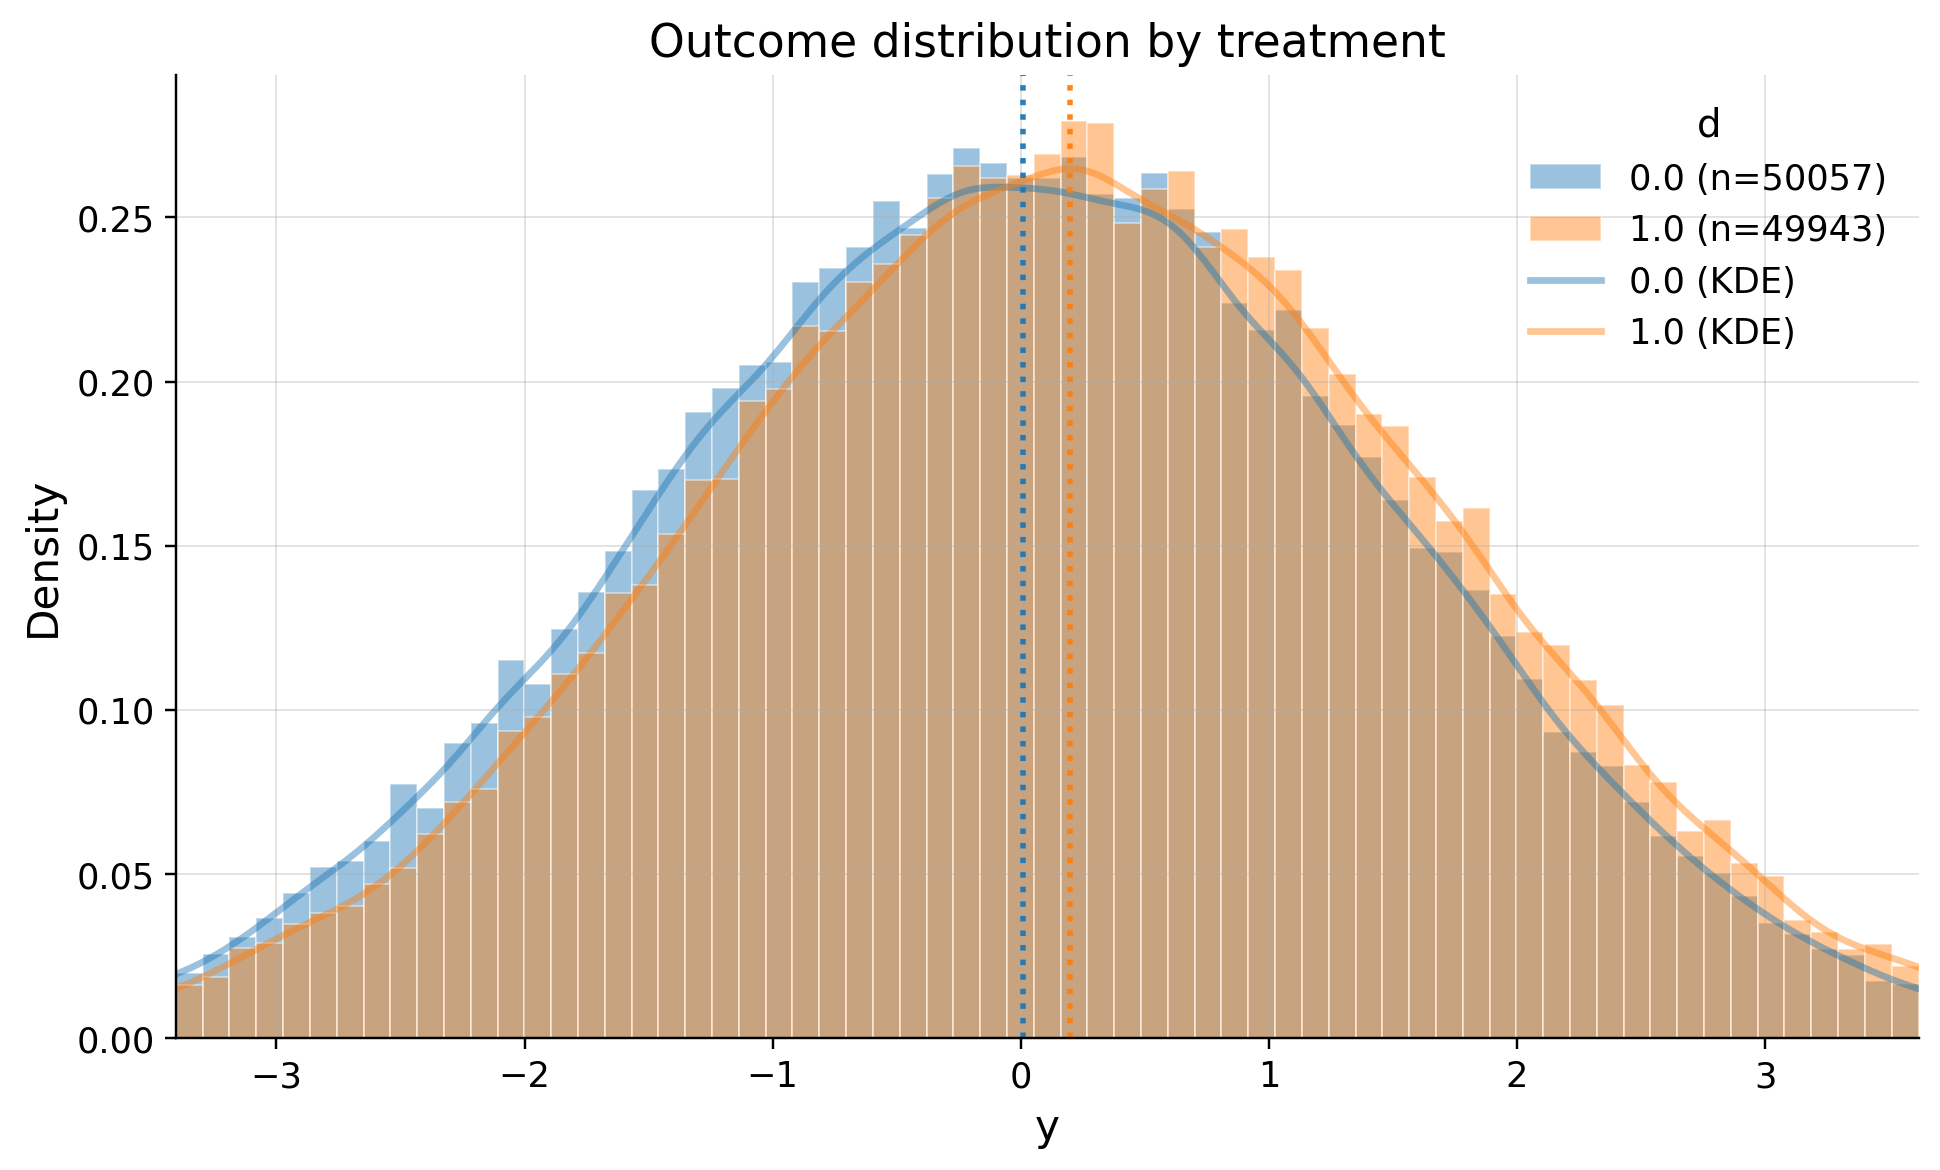

In [9]:
eda.outcome_hist()

In [10]:
# Shows means of confounders for control/treated groups, absolute differences, and SMD values
confounders_balance_df = eda.confounders_means()
display(confounders_balance_df)

,mean_t_0,mean_t_1,abs_diff,smd,ks,ks_pvalue
confounders,,,,,,
age,35.064806,35.140480,0.075674,0.008984,0.006406,0.255385
y_pre,0.004032,-0.004042,0.008074,-0.007123,0.006182,0.293687
platform_iOS,0.594902,0.592375,0.002527,-0.005144,0.002527,0.997139
platform_Android,0.405098,0.407625,0.002527,0.005144,0.002527,0.997139
invited_friend,0.084304,0.085077,0.000773,0.002777,0.000773,1.000000
cnt_trans,1.750405,1.747532,0.002872,-0.001971,0.005151,0.519128


In [11]:
model = CUPEDModel()
model.fit(data)
res = model.effect()

In [15]:
res

CupedEffect(ate=0.19611881007038967, se=0.006325868042696929, t_stat=31.002671688165293, p_value=4.948015380616318e-210, ci_low=0.183720186456712, ci_high=0.20851743368406733, alpha=0.05, nobs=100000, cov_type='HC3', use_t=True, adjustment='ancova', ate_naive=0.18802555650105562, se_naive=0.009562868317249035, variance_reduction_pct=56.24135095196503, covariates=['y_pre', 'age', 'cnt_trans', 'platform_Android', 'platform_iOS', 'invited_friend'], beta_covariates=array([ 1.00041861e+00,  3.40287808e-05,  7.90351161e-04, -3.29664881e-03,
        3.29664881e-03,  3.59560414e-04]), gamma_interactions=array([], dtype=float64))